In [1]:
import argparse
from copy import deepcopy
import logging
import random
from collections import defaultdict
from os.path import join
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import joblib
import imodels
import inspect
import os.path
import imodelsx.cache_save_utils
import sys
import torch
#path_to_repo = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

#os.chdir(path_to_repo)
#os.chdir('/home/mattyshen/interpretableDistillation')
sys.path.append('..')

import idistill.model
import idistill.data
from idistill.ftd import FTDistillRegressorCV
from idistill.whitebox_figs import FIGSRegressor

sys.path.append('/home/mattyshen/iCBM')

from CUB.template_model import End2EndModel, Inception3, MLP

class ARGS:
    def __init__(self, a_dict):
        for k in a_dict.keys():
            exec(f'self.{k} = a_dict["{k}"]')
            
def fit_model(model, X_train, y_train, feature_names, r):
    # fit the model
    fit_parameters = inspect.signature(model.fit).parameters.keys()
    if "feature_names" in fit_parameters and feature_names is not None:
        model.fit(X_train, y_train, feature_names=feature_names)
    else:
        model.fit(X_train, y_train)

    return r, model

def evaluate_model(model, X_train, X_val, y_train, y_val, comp, seed, r):
    """Evaluate model performance on each split"""
    metrics = {
            "accuracy": accuracy_score,
        }
    for split_name, (X_, y_) in zip(
        ["trainval", "test"], [(X_train, y_train), (X_val, y_val)]
    ):
        y_pred_ = model.predict(X_)
        if len(y_pred_.shape) > 1 and y_pred_.shape[1] > 1:
            #handle regressors
            y_pred_ = np.argmax(y_pred_, axis=1)
        for i, (metric_name, metric_fn) in enumerate(metrics.items()):
            print(metric_fn(y_, y_pred_))
            r[f"{comp}_seed{seed}_{metric_name}_{split_name}"] = metric_fn(y_, y_pred_)

    return r

def load_csvs(path):

    X_train = pd.read_csv(f'{path}/X_trainval.csv', index_col=0)
    X_train_hat = pd.read_csv(f'{path}/X_trainval_hat.csv', index_col=0)
    X_test = pd.read_csv(f'{path}/X_test.csv', index_col=0)
    X_test_hat = pd.read_csv(f'{path}/X_test_hat.csv', index_col=0)
    y_train = pd.read_csv(f'{path}/y_trainval.csv', index_col=0)
    y_train_hat = pd.read_csv(f'{path}/y_trainval_hat.csv', index_col=0)
    y_test = pd.read_csv(f'{path}/y_test.csv', index_col=0)
    y_test_hat = pd.read_csv(f'{path}/y_test_hat.csv', index_col=0)

    return X_train, X_train_hat, X_test, X_test_hat, y_train, y_train_hat, y_test, y_test_hat

def find_optimal_threshold(y_true, y_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

def find_thresh(linkage_matrix, min_clusters=10, max_clusters=15, step=0.1, count = 0):
    if count > 3:
        print(max_clusters)
        return find_thresh(linkage_matrix, min_clusters=min_clusters, max_clusters=(max_clusters-5*4)-1, step=step, count = 0)
    threshold = 4.9
    while threshold < 10:
        clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
        num_clusters = len(set(clusters))
        if min_clusters <= num_clusters <= max_clusters:
            return threshold, num_clusters
        threshold += step
    print('find_thresh recursive call beginning')
    return find_thresh(linkage_matrix, min_clusters=min_clusters, max_clusters=max_clusters+5, step=0.1, count = count+1)
    #return None, 0

def cluster_concepts(X, num_clusters):
    distance_matrix = 1 - X_train_hat.corr().abs()
    linkage_matrix = linkage(squareform(distance_matrix), method='ward')
    
    threshold, _ = find_thresh(linkage_matrix, min_clusters=num_clusters-5, max_clusters=num_clusters, step=0.1)
        
    clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
    
    feature_groups = {}
    for i, cluster_id in enumerate(clusters):
        feature_groups.setdefault(cluster_id, []).append(distance_matrix.columns[i])
    
    return feature_groups

def process_X(X_train, X_train_hat, X_test, X_test_hat, prepro, num_clusters, thresh=0):
    if prepro == "probs":
        return X_train_hat, X_test_hat, None
    elif prepro == 'cluster':
        f_gs = cluster_concepts(X_train_hat, num_clusters)
        optimal_thresholds = np.zeros(X_train.shape[1])
        
        for k in f_gs.keys():
            idxs = [int(s[1:]) - 1 for s in f_gs[k]]
            optimal_thresholds[idxs] = find_optimal_threshold(X_train[f_gs[k]].values.reshape(-1, ), X_train_hat[f_gs[k]].values.reshape(-1, ))

        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
    elif prepro == 'global':
        f_gs = cluster_concepts(X_train_hat, num_clusters)
        opt_thresh = find_optimal_threshold(X_train.values.reshape(-1, ), X_train_hat.values.reshape(-1, ))
        
        return (X_train_hat > opt_thresh).astype(int), (X_test_hat > opt_thresh).astype(int), f_gs
    elif prepro == 'gpt1':
        f_gs = {1:['c'+str(i) for i in range(1, 5)]+['c'+str(i) for i in range(53, 55)]+['c'+str(i) for i in range(100, 104)],
                2:['c'+str(i) for i in range(5, 11)]+['c'+str(i) for i in range(110, 113)]+['c78'],
                3:['c'+str(i) for i in range(11, 17)]+['c'+str(i) for i in range(26, 32)]+['c'+str(i) for i in range(85, 88)]+['c'+str(i) for i in range(65, 71)]+['c'+str(i) for i in range(104, 110)],
                4:['c'+str(i) for i in range(17, 24)]+['c'+str(i) for i in range(40, 51)]+['c'+str(i) for i in range(24, 26)]+['c'+str(i) for i in range(71, 78)]+['c'+str(i) for i in range(60, 65)],
                5:['c'+str(i) for i in range(32, 38)]+['c'+str(i) for i in range(88, 91)],
                6:['c38', 'c39', 'c51','c52']+['c'+str(i) for i in range(55, 60)],
                7:['c'+str(i) for i in range(97, 100)],
                8:['c'+str(i) for i in range(91, 97)]+['c'+str(i) for i in range(79, 85)]
        }
        
        optimal_thresholds = np.zeros(X_train.shape[1])
        
        for k in f_gs.keys():
            idxs = [int(s[1:]) - 1 for s in f_gs[k]]
            optimal_thresholds[idxs] = find_optimal_threshold(X_train[f_gs[k]].values.reshape(-1, ), X_train_hat[f_gs[k]].values.reshape(-1, ))

        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
    elif prepro == 'gpt2':
        f_gs = {1:['c'+str(i) for i in range(1, 5)]+['c'+str(i) for i in range(53, 55)]+['c32']+['c'+str(i) for i in range(78, 85)],
                2:['c'+str(i) for i in range(5, 11)]+['c'+str(i) for i in range(110, 113)]+['c'+str(i) for i in range(33, 38)]+['c'+str(i) for i in range(88, 91)],
                3:['c'+str(i) for i in range(91, 97)]+['c'+str(i) for i in range(11, 17)]+['c'+str(i) for i in range(26, 32)]+['c'+str(i) for i in range(85, 88)]+['c'+str(i) for i in range(17, 24)]+['c'+str(i) for i in range(60, 65)],
                4:['c'+str(i) for i in range(40, 51)]+['c24', 'c25']+['c'+str(i) for i in range(104, 110)]+['c'+str(i) for i in range(55, 60)]+['c'+str(i) for i in range(65, 78)],
                5:['c38', 'c39', 'c51','c52'],
                6:['c'+str(i) for i in range(100, 104)]+['c'+str(i) for i in range(97, 100)]
        }
        
        optimal_thresholds = np.zeros(X_train.shape[1])
        
        for k in f_gs.keys():
            idxs = [int(s[1:]) - 1 for s in f_gs[k]]
            optimal_thresholds[idxs] = find_optimal_threshold(X_train[f_gs[k]].values.reshape(-1, ), X_train_hat[f_gs[k]].values.reshape(-1, ))

        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
    elif prepro == 'gpt3':
        f_gs = {1:['c'+str(i) for i in range(1, 5)]+['c53', 'c54']+['c'+str(i) for i in range(100, 104)],
                2:['c78', 'c32']+['c'+str(i) for i in range(5, 11)]+['c'+str(i) for i in range(110, 113)]+['c'+str(i) for i in range(88, 91)]+['c'+str(i) for i in range(33, 38)],
                3:['c'+str(i) for i in range(91, 97)]+['c'+str(i) for i in range(11, 24)]+['c'+str(i) for i in range(26, 32)]+['c'+str(i) for i in range(85, 88)]+['c'+str(i) for i in range(55, 78)]+['c'+str(i) for i in range(104, 110)],
                4:['c'+str(i) for i in range(40, 51)]+['c24', 'c25', 'c38', 'c39', 'c51', 'c52'],
                5:['c'+str(i) for i in range(79, 85)],
                6:['c'+str(i) for i in range(97, 100)]
        }
        
        optimal_thresholds = np.zeros(X_train.shape[1])
        
        for k in f_gs.keys():
            idxs = [int(s[1:]) - 1 for s in f_gs[k]]
            optimal_thresholds[idxs] = find_optimal_threshold(X_train[f_gs[k]].values.reshape(-1, ), X_train_hat[f_gs[k]].values.reshape(-1, ))

        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
    
    elif prepro == 'gpt4':
        f_gs = {1:[1,3,5,7,8,11,12,15,16,19,20,21,22,24,26,27,40,41,42,43,46,49,50,53,55,56,60,62,64,65,66,69,70,71,72,77,78,79,80,83,84,85,87,88,90,91,92,93,94,95,102,106,107,108,110],
                2:[4,6,10,13,14,17,18,23,25,29,54,73,76,86,89,97,98,104,105,111],
                3:[2,9,28,30,32,33,34,35,36,37,38,39,47,48,51,52,81,96,99],
                4:[31,44,45,57,58,59,61,63,67,68,74,75,82,100,101,103,109,112]
        }
        
        for k in f_gs.keys():
            f_gs[k] = ['c'+str(i) for i in f_gs[k]]
        
        optimal_thresholds = np.zeros(X_train.shape[1])
        
        for k in f_gs.keys():
            idxs = [int(s[1:]) - 1 for s in f_gs[k]]
            optimal_thresholds[idxs] = find_optimal_threshold(X_train[f_gs[k]].values.reshape(-1, ), X_train_hat[f_gs[k]].values.reshape(-1, ))

        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
        
    elif prepro == 'binary' and thresh > 0:
        f_gs = cluster_concepts(X_train_hat, num_clusters)
        return (X_train_hat > thresh).astype(int), (X_test_hat > thresh).astype(int), f_gs
    else:
        f_gs = cluster_concepts(X_train_hat, num_clusters)
        optimal_thresholds = []
        for class_idx in range(X_train_hat.shape[1]):
            y_true_class = X_train.iloc[:, class_idx]
            y_probs_class = X_train_hat.iloc[:, class_idx]
            optimal_thresholds.append(find_optimal_threshold(y_true_class, y_probs_class))
        optimal_thresholds = np.array(optimal_thresholds)
        
        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
    
def process_y(y_train, y_train_hat, y_test, y_test_hat, prepro):
    if prepro == "probs":
        return softmax(y_train_hat, axis=1), softmax(y_test_hat, axis=1)
    elif prepro == "classes":
        return pd.DataFrame(y_train_hat.idxmax(axis=1).astype(int)), pd.DataFrame(y_test_hat.idxmax(axis=1).astype(int))
    else:
        return y_train_hat, y_test_hat

/home/mattyshen/anaconda3/lib/python3.9/site-packages/aiohttp/helpers.py:107: DeprecationWarning: "@coroutine" decorator is deprecated since Python 3.8, use "async def" instead
  def noop(*args, **kwargs):  # type: ignore
2025-01-19 15:07:55.354130: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 15:07:56.281096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mattyshen/anaconda3/lib/python3.9/site-packages/botocore/httpsession.py:34: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as

In [2]:
args_dict = {}
args_dict['task_type'] = 'regression'
args_dict['model_name'] = 'FIGSRegressor'
args_dict['X_type'] = 'binary'
args_dict['thresh'] = 0.45
args_dict['Y_type'] = 'logits'
args_dict['max_rules'] = 90
args_dict['max_trees'] = 30
args_dict['max_depth'] = 3
args_dict['device'] = 'cuda:0'
args_dict['num_clusters'] = 5
args_dict['num_bootstraps'] = 2

args = ARGS(args_dict)
r = {}

In [3]:
X_train, X_train_hat, X_test, X_test_hat, y_train, y_train_hat, y_test, y_test_hat = load_csvs(f'/home/mattyshen/DistillationEdit/data/cub_tabular/seed0_Joint0.01SigmoidModel__Seed1')

In [4]:
X_train_model, X_test_model, clusters = process_X(X_train, X_train_hat, X_test, X_test_hat, args.X_type, args.num_clusters, args.thresh)
y_train_model, y_test_model = process_y(y_train, y_train_hat, y_test, y_test_hat, args.Y_type)

In [6]:
model = FIGSRegressor(max_rules = args.max_rules, max_trees = args.max_trees, max_depth = args.max_depth)
r, model = fit_model(model, X_train_model, y_train_model, None, r)

In [326]:
model

FIGSRegressor(max_depth=3, max_rules=90, max_trees=60)

In [363]:
model.trees_[0].left.left.left.right

array([ 5.07404749e-01, -2.44922653e-01,  6.97383533e-01, -6.25487011e-01,
       -9.77022417e-01, -4.70640939e-01, -5.35136941e-01, -1.06622819e+00,
       -5.10568492e-01, -5.94699558e-01,  3.44396871e-03, -3.78235504e-01,
       -6.18439505e-01,  1.24701787e-01,  3.14621123e-01,  3.02500755e-01,
        7.71578839e-01,  5.54138616e-01,  6.46167919e-01,  3.88725268e-01,
       -1.10859092e-01, -1.19298852e+00, -1.07696207e+00, -1.17460364e+00,
       -1.42327809e+00, -6.56544206e-01, -1.88406567e-01, -9.59713362e-01,
       -2.99880651e-01, -4.13370995e-01,  1.56506875e-01,  7.03688276e-01,
        3.16147437e-01, -4.57762468e-01,  4.28537606e-01, -4.77703760e-01,
        1.10354696e+00,  2.22112212e-01,  1.22293812e+00,  7.96750035e-01,
        8.07266907e-01,  8.51233947e-01,  1.12106840e+00, -3.37480205e-01,
        7.08377396e-01, -6.42500202e-01,  1.45531854e-01, -1.70047316e-01,
        1.60800616e-01, -3.05083657e-01,  1.68856069e-01, -9.59066195e-01,
       -6.74009342e-01, -

In [321]:
type(class_corr.values[:, 0] - 0.507

array([ 0.01062529, -0.57496043, -0.74938773, -1.19698406, -0.91982768,
       -0.17176373, -0.94511379, -0.48965964, -0.64473968,  2.13630483,
       -1.11695073, -1.70784567, -0.28884582, -0.54431079, -1.07823821,
       -1.46193175, -0.25989318, -0.45752061, -0.70529442, -0.97159297,
       -0.87487412, -1.32803634,  0.54376154,  0.69017365, -0.7198147 ,
       -1.12886711, -0.28316337, -0.01308914, -0.45677471, -0.64560364,
       -0.89816234, -0.41043486, -0.36018971, -0.11564827, -0.67834947,
       -0.82033355, -0.39999153, -0.50997526, -0.81538456, -0.15146509,
       -0.84836611, -0.66945081, -0.36999518, -0.08774998, -0.5554978 ,
       -0.62806498, -0.30435385, -0.59667217, -0.7194636 , -0.24692336,
       -0.33158289, -0.57836784, -0.2714713 , -0.67760355, -0.46306482,
       -0.40898113, -0.79335174, -0.53657756, -0.58638216, -0.98832937,
       -0.405929  , -0.47287789, -1.10833967, -0.74973282, -0.44692661,
       -0.17004057, -0.58085336, -0.58393854, -0.77991039, -0.50

In [365]:
def extract_interactions(model):
    """
    Extracts all feature interactions from the FIGS model by parsing through each additive tree.

    Parameters:
        model: A FIGS model containing an attribute `trees_`.
               Each tree is comprised of hierarchically linked `Node` objects.

    Returns:
        interactions: A list of sets, where each set contains the features involved in an interaction.
    """
    interactions = []

    def traverse_tree(node, current_features, current_depth):
        """
        Recursively traverse a tree to collect feature interactions.

        Parameters:
            node: The current `Node` object in the tree.
            current_features: A set of features encountered so far in the current path.
        """
        if node.left is None and node.right is None:
            cur_interactions.append((current_features, node.value))
            return

        # Add the current feature to the set of features for this path

        # If the node has children, traverse them
        if node.left is not None:
            current_features_l = current_features.copy()
            current_features_l.append('c' + str(node.feature+1))
            traverse_tree(node.left, current_features_l.copy(), current_depth=current_depth+1)
        if node.right is not None:
            current_features_r = current_features.copy()
            current_features_r.append('!c' + str(node.feature+1))
            traverse_tree(node.right, current_features_r.copy(), current_depth=current_depth+1)

    # Loop through each tree in the model
    # traverse_tree(model.trees_[0], set(), current_depth=0)
    # return interactions
    for tree in model.trees_:
        # Start traversal for each tree
        cur_interactions = []
        traverse_tree(tree, [], current_depth=0)
        interactions.append(cur_interactions)
    return interactions

In [366]:
len(model.trees_[0].value)

200

In [367]:
cur_interactions = extract_interactions(model)

In [453]:
model

FIGSRegressor(max_depth=3, max_rules=90, max_trees=60)

In [454]:
class_corr[0]

c5,c94,c8        0.507405
c5,c94,!c8       0.213993
c5,!c94,c20      0.019480
c5,!c94,!c20     0.079649
!c5,c55,c64     -0.136270
!c5,c55,!c64     0.153655
!c5,!c55,c64    -0.191205
!c5,!c55,!c64    0.037196
Name: 0, dtype: float64

In [355]:
X_train_figs = pd.DataFrame()

In [473]:
X_train_figs = []
class_corr = []
for i, tree in enumerate(cur_interactions):
    for j, (t_i, v) in enumerate(tree):
        cur_inter = pd.Series(np.ones(X_train_model.shape[0]))
        for c in t_i:
            if c[0] == '!':
                cur_inter *= (X_train_model[c[1:]] > 0.5)
            else:
                cur_inter *= (X_train_model[c] <= 0.5)
                
        X_train_figs.append(pd.Series(cur_inter, name = ','.join(cur_interactions[i][j][0])))
        class_corr.append(pd.Series(v, name = ','.join(cur_interactions[i][j][0])))
X_train_figs = pd.concat(X_train_figs, axis = 1)
class_corr = pd.concat(class_corr, axis = 1).T

In [474]:
X_train_figs.sum(axis = 1).value_counts()

33.0    5984
dtype: int64

In [468]:
class_corr.shape

(8, 200)

In [479]:
partial_preds=model.predict(X_train_model)

In [487]:
np.mean(abs(np.sum(partial_preds, axis =2) - (X_train_figs @class_corr).values) < 0.001)

1.0

In [ ]:
pd.Series(partial_preds[:, 0]).value_counts()

 0.507405    2119
 0.019480     836
 0.213993     760
 0.079649     746
-0.191205     539
-0.136270     506
 0.037196     240
 0.153655     238
dtype: int64

In [488]:
pd.DataFrame(np.sum(model.predict(X_train_model), axis = 2))

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-1.061335,-1.918173,-0.371776,3.126519,0.590886,0.992966,0.710823,0.466402,3.323268,3.112069,...,0.337213,0.577728,-0.464751,-0.176065,-0.995886,-1.342257,-0.243231,-1.113967,-0.712423,0.385607
1,0.331965,0.332635,-1.678948,-0.419434,-1.082148,-1.800195,-0.135066,-1.625050,-0.234397,-1.850129,...,-1.262579,-1.631193,4.343615,0.403480,3.698064,2.792370,2.595417,2.046096,1.352551,2.416452
2,-0.796089,-1.572673,-1.396252,-0.502862,0.153205,-0.034209,-0.985450,0.304982,-0.138096,1.997618,...,2.185157,0.762634,0.051570,1.406762,-1.150658,-1.437108,-0.812772,-1.820564,-0.660213,0.803638
3,-1.239948,0.372104,-0.951029,1.083382,1.388393,2.326500,3.418237,0.128191,0.920349,0.768650,...,3.539799,4.288039,-0.671112,0.578206,-2.339924,-3.028648,-0.367099,-0.653108,-1.819090,-1.259301
4,-1.656941,-1.421315,-0.637516,-0.557980,-1.637246,0.874678,2.131871,-1.921641,-0.567042,-0.376569,...,-0.260871,1.803123,-1.678753,-2.574507,-2.262804,-2.420432,-0.034179,-1.457495,-2.382331,0.043781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5979,-1.671400,-1.249825,-1.605623,1.665805,0.739771,1.012770,-0.017719,-0.697428,1.439982,1.007662,...,0.501498,0.760830,-0.809412,3.272303,0.356043,1.497809,1.420819,0.185318,0.579134,-0.339781
5980,1.485334,1.599280,1.215589,-1.132256,-1.316257,0.341225,1.201344,-0.621002,-0.972495,-2.268111,...,2.673976,1.800117,-0.743286,-1.120641,-1.492058,-1.794591,-0.765719,0.856344,-2.566189,0.117962
5981,5.361357,2.700149,4.343188,-1.177720,0.180382,-0.204762,-0.115242,0.952955,-0.794201,-1.150696,...,0.771919,-1.538227,-0.482505,-0.985409,-1.147200,-0.703112,-1.068928,0.293541,-1.087155,-1.072671
5982,2.644442,3.123842,2.429797,0.125389,1.640236,1.580344,3.604375,1.970283,0.533627,-1.061464,...,0.863204,1.537604,-0.980783,-1.260145,-2.687612,-2.945793,-1.291912,-0.467149,-2.824483,-1.181430


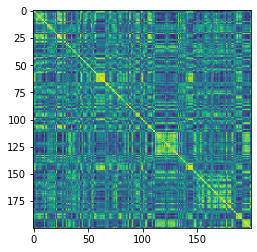

In [489]:
import matplotlib.pyplot as plt
plt.imshow(class_corr.corr())

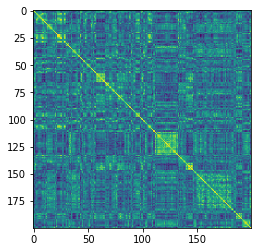

In [490]:
plt.imshow(class_corr.apply(lambda row: class_corr.shape[1] - row.rank().astype(int) + 1, axis=0).corr())

In [ ]:
#postprocess

In [208]:
preds = model.predict(X_train_model)

In [195]:
accuracy_score(np.argmax(np.sum(model.predict(X_test_model), axis = 2), axis = 1), y_test)

0.7682084915429755

In [503]:
from sklearn.multioutput import MultiOutputRegressor

In [504]:
figs_new = MultiOutputRegressor(RidgeCV(alphas = np.arange(0.01, 1.5, 0.1)))

In [505]:
figs_new.fit(X_train_figs, y_train_model)

MultiOutputRegressor(estimator=RidgeCV(alphas=array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,
       1.11, 1.21, 1.31, 1.41])))

In [507]:
accuracy_score(np.argmax(figs_new.predict(X_test_figs), axis = 1), y_test)

0.7699344149119779

In [492]:
r2_score(ridge.predict(X_train_figs.values), y_train_model.values[:, 1])

0.9734207321038125

In [493]:
r2_score(np.sum(model.predict(X_train_model), axis = 2)[:,1],y_train_model.values[:, 1])

0.9446525488412153

In [497]:
X_test_figs = []
for i, tree in enumerate(cur_interactions):
    for j, (t_i, v) in enumerate(tree):
        cur_inter = pd.Series(np.ones(X_test_model.shape[0]))
        for c in t_i:
            if c[0] == '!':
                cur_inter *= (X_test_model[c[1:]] > 0.5)
            else:
                cur_inter *= (X_test_model[c] <= 0.5)
        X_test_figs.append(pd.Series(cur_inter, name = ','.join(cur_interactions[i][j][0])))        
X_test_figs = pd.concat(X_test_figs, axis = 1)

In [498]:
r2_score(ridge.predict(X_test_figs.values), y_test_model.values[:, 1])

0.9552247539960633

In [499]:
r2_score(np.sum(model.predict(X_test_model), axis = 2)[:,1], y_test_model.values[:, 1])

0.9317465167931385

In [520]:
figs_new.estimators_[1].alpha_

0.21000000000000002

(array([ 2.,  0.,  6., 19., 44., 36.,  6.,  6.,  3.,  1.]),
 array([-1.01571049, -0.80587157, -0.59603265, -0.38619374, -0.17635482,
         0.0334841 ,  0.24332301,  0.45316193,  0.66300084,  0.87283976,
         1.08267868]),
 <BarContainer object of 10 artists>)

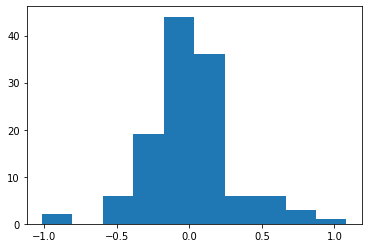

In [515]:
plt.hist(figs_new.estimators_[2].coef_)

In [511]:
figs_new.estimators_[0].coef_.shape

(123,)

(array([ 5.,  6., 72., 31.,  6.,  1.,  1.,  0.,  0.,  1.]),
 array([-1.12744403, -0.72717022, -0.32689642,  0.07337739,  0.4736512 ,
         0.873925  ,  1.27419881,  1.67447261,  2.07474642,  2.47502023,
         2.87529403]),
 <BarContainer object of 10 artists>)

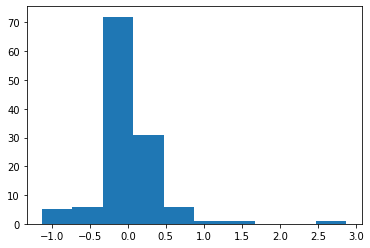

In [516]:
plt.hist(class_corr.iloc[:, 2])

In [518]:
np.mean(figs_new.estimators_[10].coef_), np.mean(class_corr.iloc[:, 10])

(5.469879292055649e-16, 0.04829440182450091)